# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Откройте файл с данными и изучите общую информацию

Загружаем библиотеки, которые планируем использовать

In [1]:
import pandas as pd
import seaborn
from scipy.stats.mstats import mode
import matplotlib.pyplot as plt
from pymystem3 import Mystem

Открываем файл с данными

In [2]:
loaners_data = pd.read_csv('~/data.csv')

In [3]:
loaners_data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


Проведем предварительный обзор данных. По всей видимости данных достаточно для ответа на поставленные заказчиком вопросы.

In [4]:
loaners_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Таблица имеет 12 столбцов и содержит 21525 строк.

Для столбцов предоставлено следующее описание:

- children — количество детей в семье (тип данных int64)

- days_employed — общий трудовой стаж в днях (тип данных float64) **имеются пропуски значений**

- dob_years — возраст клиента в годах (тип данных int64)

- education — уровень образования клиента (тип данных object)

- education_id — идентификатор уровня образования (тип данных int64)

- family_status — семейное положение (тип данных object)

- family_status_id — идентификатор семейного положения (тип данных int64)

- gender — пол клиента (тип данных object)

- income_type — тип занятости (тип данных object)

- debt — имел ли задолженность по возврату кредитов (тип данных int64)

- total_income — ежемесячный доход (тип данных float64) **имеются пропуски значений, количество пропусков значений равно количеству пропусков в столбце days_employed**

- purpose — цель получения кредита (тип данных object)


In [5]:
loaners_data.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


По описанию числовых значений в таблице можно сделать следующие предположения:
- В столбце children имеются значения 20 и -1, которые вероятнее всего являются опечатками, которые нужно исправить на этапе предобработки, поскольку данные этого столбца важны для ответа на вопрос заказчика
- В столбце days_emloyed содержатся странные значения, которые не соответствуют описанию данных, предоставленных заказчиком, для более детального описания необходимо взглянуть на значения в столбце более пристально. Хотя возможно это не потребуется, поскольку заказчика в настоящее время не интересует зависимость возврата долга от текущего трудового стажа. Так же в этом столбце присутствут пропуски.
- В столбце dob_years настораживает только значения равные 0, для более точного предположения необходимо взглянуть на столбец отдельно. Так же логично было бы перевести значения к типу целых чисел, поскольку описание предполагает, что столбец содержит количество полных лет. В целом же заказчика не интересует зависимость возврата кредита от возраста заемщика.
- В столбце education_id содержатся значения кодов для видов образования. На первый взгляд данные хорошие.
- В столбце family_status_id содержатся значения кодов для видов семейного пложения. На первый взгляд данные хорошие.
- В столбце debt содержатся сведения о просрочке платежа по кредиту. Самый важный столбец, по которому будет проводится все исследование. На первый взгляд данные хорошие. Уже на этом этапе видно, что в среднем по выборке доля кредитов с просроченными платежами составляет приблизительно 8.1%.
- В столбце total_income содержатся данные о доходе заемщиков. По первому взгляду на описание сложно сказать все ли с хорошо со значениями, необходимо взглянуть на столбец внимательнее

In [6]:
loaners_data.education.value_counts()

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education, dtype: int64

В столбце education большое количество неявных дубликатов.

In [7]:
loaners_data.family_status.value_counts()

женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

В столбце family_status неявных дубликатов невыявлено. Столбец можно использовать для выделения категорий.

In [8]:
loaners_data.gender.value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

В столбце gender данные выглядят хорошо, за исключением одного значения, возможно стоить заменить его на F поскольку в выборке значение F встречается чаще

In [9]:
loaners_data.income_type.value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: income_type, dtype: int64

В столбце income_type имеются единичные значения, необходимо проверить как эти значения влияют на распределение среднего дохода по выборке.

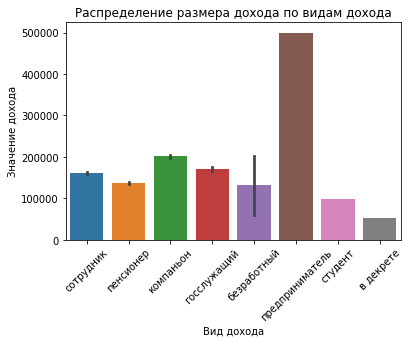

In [10]:
income_plot = seaborn.barplot(x=loaners_data.income_type, y=loaners_data.total_income)
income_plot.set(xlabel='Вид дохода', ylabel='Значение дохода', title='Распределение размера дохода по видам дохода')
plt.xticks(rotation=45)
plt.show()

На графике видно, что доход предпринимателей значительно превышает доход всех остальных категорий, а значение в декрете значительно меньше остальных. Такие выбросы сильно исказят среднее значение по всей выборке. Для заполнения пропусков необходимо использовать среднее значение по каждой категории отдельно.

In [11]:
loaners_data.purpose.value_counts()

свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции с недвижимостью                  676
покупка коммерческой недвижимости         664
покупка жилья для сдачи                   653
операции с жильем                         653
операции с коммерческой недвижимостью     651
покупка жилья                             647
жилье                                     647
покупка жилья для семьи                   641
строительство собственной недвижимости    635
недвижимость                              634
операции со своей недвижимостью           630
строительство жилой недвижимости          626
покупка недвижимости                      624
покупка своего жилья                      620
строительство недвижимости                620
ремонт жилью                              612
покупка жилой недвижимости                607
на покупку своего автомобиля              505
заняться высшим образованием      

Столбец purpose содержит большое количество различных целей кредита, при этом есть возможность свести это количество к более общим категориям.

Я планирую выделить 4 категории:
* Свадьба
* Недвижимость и жилье (планирую объеденить в одну категорию и жилье и коммерческую недвижимость, потому что недвижимость любая - это хороший залог для кредита, для более детального исследовани можно поделить эти категории и посмотреть различие между коммерческой недвижимостью и жилой)
* Авто
* Образование

**Вывод**
Таблица содержит достаточно данных для ответа на вопросы заказчика, однако преварительно необходимо провести предобработку данных.
- Необходимо исправить опечатки в стобце children.
- Необходимо заполнить пропуски в столбце total_income, поскольку пропуски составляют примерно 10% выборки, и формулирование выводов без пропущенных значений может исказить реальные результаты. Для заполнения пропусков необходимо выяснить к какому типу дохода(income_type) относятся пропущенные значения и заполнить средним по категории.
- Необходимо выявить соответствие между education_id и текстовым представлением вида образования в education, чтобы правильно сформировать категории образования.
- Необходимо провести лемматизацию, чтобы сформировать категории целей кредита.



## Предобработка данных

**Исправление опечаток в столбце children**

Поскольку на этапе предаврительного просмотра были выявлены значения в столбце children, появление которых в реальной жизни невозможно или крайне маловероятно, необходимо заменить их на наиболее вероятные.

In [12]:
loaners_data.children = loaners_data.children.replace(to_replace={20:2, -1:1})

In [13]:
loaners_data.children.value_counts()

0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64

### Обработка пропусков

В первую очередь заполним пропуски в столбце total_income, потому что значения из этого столбца будут использоваться в исследовании для оценки качества кредита от дохода заемщика.

In [14]:
na_data = loaners_data[loaners_data.total_income.isna()] # выделим в отдельную таблицу строки с пропущенными значениями в столбце total_income
types_to_fill = na_data.income_type.unique() # в отдельную переменную сохраним уникальные значения типа дохода с пропущенными значениями в столбце total_income



In [15]:
mean_income_groupedby_income_type = loaners_data.groupby('income_type')['total_income'].mean() # в переменную сохраним средние значения общего дохода сгруппированные по виду дохода


In [16]:
def fill_na_income_with_mean(df, type_to_fill, mean_income):
    '''функция принимает датафрейм в котором нужно заменить пропущенные значения в столбце total_income, следом принимает наименования типов дохода, в которых были выявлены пропущенные значения, третьим аргументом принимает объект содержащий средние значения по типам дохода без учета пропущенных значений
    На выходе получаем обновленный датафрейм с пропущенными значениями заполненными средним по виду дохода
    '''
    for item in type_to_fill:
        df.loc[(df.income_type == item) & (df.total_income.isna()), 'total_income'] = mean_income[item]

Применим функцию для нашей таблицы, вторым аргументом подадим значения уникальных видов дохода, в которых найдены пропущенные значения, третьим аргументом средние значения по виду, которые нужно подставить.

In [17]:
fill_na_income_with_mean(loaners_data, types_to_fill, mean_income_groupedby_income_type)



In [18]:
loaners_data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income           0
purpose                0
dtype: int64

Пропущенные значения в столбце total_income заполнены

Для целей исследования обрабатывать пропущенные значения в столбце days_employed не обязательно, но вероятно эти данные также можно использовать для построения скоринговой модели. В ходе проекта мы заменим пропущенные значения на медианное количество рабочих дней по возрасту работника.


In [19]:
ages_with_na = loaners_data[loaners_data.days_employed.isna()].dob_years.unique() # находим уникальные значения возраста заемщиков с пропущенными значениями в столбце days_employed
median_days_employed_by_age = loaners_data.groupby('dob_years')['days_employed'].median() # сохраняем в переменную значения медианы для каждого возраста


In [20]:
def fill_na_days_with_median(df, age_to_fill, median_to_fill):
    ''' Функция принимает три аргумента, датафрейм, значения возраста заемщика и медианное значение по возрасту
        В результате работы функции пропущенные значения в датафреме заменяются на медианное значение по соответсвующему значению в столбце возраст
    '''
    for age in age_to_fill:
        df.loc[(df.dob_years == age) & (df.days_employed.isna()), 'days_employed'] = median_to_fill[age]

In [21]:
fill_na_days_with_median(loaners_data, ages_with_na, median_days_employed_by_age) # подставляем в функцию значения наших переменных

In [22]:
loaners_data.isna().sum() # проверяем наличие пропусков

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

**Вывод**
Проведена работа по заполнению пропущенных значений. Вероятно пропущенные значения появились по технической причине, так как пропуски появились в двух столбцах одновременно.
- Значения в столбце total_income заполнены средним значением по типу занятости заемщика
- Значения в столбце days_employed заполнены медианной значений по возрасту заемщика

Значения в столбце days_employed выглядят странно, если по отрицательным значениям можно предположить, что это количество дней от даты получения кредита до даты приема на текущую работу в обратную сторону (со знаком минус), то по положительным значениям предположить происхождение сложно, цифры слишком большие (максимальное значение составляет 400000, что в переводе на годы даст более 1000 лет, нужно общаться с заказчиком по поводу происхождения таких значений)

### Замена типа данных

В описании к данным сказано, что значения в столбце days_employed хранят целое количество дней трудового стажа. В реальности данные имеют тип float. Чтобы привести данные к целочисленному изменим тип значений в столбце.

In [23]:
try:
    loaners_data['days_employed'] = loaners_data['days_employed'].astype(int)
except:
    print('Что-то не так')

In [24]:
loaners_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       21525 non-null int64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null float64
purpose             21525 non-null object
dtypes: float64(1), int64(6), object(5)
memory usage: 2.0+ MB


**Вывод**

Значения в столбце days_employed приведено к целочисленному типу данных

### Обработка дубликатов

В столбце education выявлено наличие неявных дубликатов, на первый взгляд кажется, что значения идентичны, но занесены в разном регистре. Вероятно отсутствует единый подход к заполнению данных. Попробуем заменить значения в столбце, теми же самыми значениями, только в нижнем регистре.

In [25]:
loaners_data['education'] = loaners_data.education.str.lower()


In [26]:
loaners_data.education.value_counts()

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

**Вывод**

Неявные дубликаты в столбце education устранены.

### Лемматизация


Проведем лемматизацию для уникальных значений в столбце цель получения кредита (purpose)

In [27]:
m = Mystem()
lemmas = {}
unique_purposes = loaners_data.purpose.unique().tolist()
for purpose in unique_purposes:
    lemmas[purpose] = m.lemmatize(purpose.strip())



In [28]:
category_dict = {'недвижимость': [], 'авто': [], 'свадьба': [], 'образование': []}
for key in lemmas:
    if 'недвижимость' in lemmas[key] or 'жилье' in lemmas[key]:
        category_dict['недвижимость'].append(key)
    if 'автомобиль' in lemmas[key]:
        category_dict['авто'].append(key)
    if 'свадьба' in lemmas[key]:
        category_dict['свадьба'].append(key)
    if 'образование' in lemmas[key]:
        category_dict['образование'].append(key)


Развернем получившийся словарь так, чтобы каждому значению уникальной цели соответствовало значение определенной категории

In [29]:
dict_to_replace = {item: key for key, value in category_dict.items() for item in value}


Полученный словарь используем для заполнения нового столбца в датафрейме, который в дельнейшем можно будет использовать для ответа на вопросы заказчика

In [30]:
loaners_data['purpose_category'] = loaners_data['purpose']
loaners_data['purpose_category'] = loaners_data['purpose_category'].replace(to_replace=dict_to_replace)
loaners_data.purpose_category.value_counts()

недвижимость    10840
авто             4315
образование      4022
свадьба          2348
Name: purpose_category, dtype: int64

**Вывод**

На данном этапе проведена лемматизация значений в столбце цель кредита, получены леммы, и выделены общие категории, по которым можно провести исследование о зависимости цели кредита и вероятности наличия пропущенных платежей.

### Категоризация данных

На данном этапе проведем категоризацию значений в двух столбцах:
- Для столбца children выделим две категории - "есть дети" и "нет детей", чтобы ответить на вопрос заказчика о зависимости наличия детей на наличие пропущенных платежей по кредиту.
- Для столбца total_income выделим три категории в зависимости от значений уровня дохода - нижние 30%, между 30 и 70 % и верхние 70%. Для выделения категорий используем квантили.

Определим функцию для категорий наличия детей

In [31]:
def children_catogory(children):
    if children < 1:
        return 'Нет детей'
    else:
        return 'Есть дети'

Создадим новый столбец в таблице для категории наличия детей

In [32]:
loaners_data['children_category'] = loaners_data.children.apply(children_catogory)
loaners_data['children_category'].value_counts()

Нет детей    14149
Есть дети     7376
Name: children_category, dtype: int64

Запишем в переменные значения 30 и 70 квантилей по уровню дохода

In [33]:
quantile_30 = loaners_data.total_income.quantile(q=0.3)
quantile_70 = loaners_data.total_income.quantile(q=0.7)

Определим функцию для выделения категорий по уровню дохода

In [34]:
def income_category(total_income):
    if total_income <= quantile_30:
        return 'Нижние 30 %'
    elif total_income <= quantile_70:
        return 'Между 30 и 70 %'
    else:
        return 'Верхние 70 %'

Применим функцию к столбцу total_income для образования категорий

In [35]:
loaners_data['income_category'] = loaners_data.total_income.apply(income_category)
loaners_data['income_category'].value_counts()

Между 30 и 70 %    8609
Нижние 30 %        6458
Верхние 70 %       6458
Name: income_category, dtype: int64

**Вывод**

На данном этапе были выделены категории по значениям столбцов children и total_income данные категории будем использовать при ответе на вопросы заказчика

## Ответьте на вопросы

Для начала сохраним в переменную среднее по выборке значение просроченных платежей, с которой будем проводить сравнение наших данных.

In [36]:
apriory_mean = loaners_data.debt.mean()


In [37]:
def comparison_df(df, column):
    mean_series = df.groupby(column)['debt'].mean()
    comparison = pd.DataFrame(data=mean_series)
    comparison['apriory'] = apriory_mean
    comparison.columns = ['Вероятность просроченного платежа в зависимости от категории', 'Средняя вероятность просроченного     платежа']
    return (comparison
    .style
    .format("{:.2%}")
    .background_gradient(cmap='Blues', axis=1))

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [38]:
comparison_df(loaners_data,'children_category')

,Вероятность просроченного платежа в зависимости от категории,Средняя вероятность просроченного платежа
children_category,,
Есть дети,9.19%,8.09%
Нет детей,7.51%,8.09%


In [39]:
comparison_df(loaners_data,'children')

,Вероятность просроченного платежа в зависимости от категории,Средняя вероятность просроченного платежа
children,,
0,7.51%,8.09%
1,9.15%,8.09%
2,9.48%,8.09%
3,8.18%,8.09%
4,9.76%,8.09%
5,0.00%,8.09%


**Вывод**

Зависимость между возвратом кредита в срок и наличем детей есть. У заемщиков с детьми выше вероятность просрочить платеж по кредиту.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [40]:
comparison_df(loaners_data,'family_status')

,Вероятность просроченного платежа в зависимости от категории,Средняя вероятность просроченного платежа
family_status,,
Не женат / не замужем,9.74%,8.09%
в разводе,7.11%,8.09%
вдовец / вдова,6.56%,8.09%
гражданский брак,9.29%,8.09%
женат / замужем,7.52%,8.09%


**Вывод**
Зависимость от семейного положения и возвратом кредита в срок есть. Заемщики, которые находящиеся в официальном браке и которые были в официальном браке возвращают кредит лучше.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [41]:
comparison_df(loaners_data,'income_category')

,Вероятность просроченного платежа в зависимости от категории,Средняя вероятность просроченного платежа
income_category,,
Верхние 70 %,7.26%,8.09%
Между 30 и 70 %,8.69%,8.09%
Нижние 30 %,8.11%,8.09%


**Вывод**

Зависимость между уровнем дохода и возвратом кредита в срок есть, заемщики, которые уровень дохода которых выше 70 % по выборке возвращают кредит лучше. При этом остальные заемщики возвращают кредит не значительно хуже, чем в среднем по всей выборке.

- Как разные цели кредита влияют на его возврат в срок?

In [42]:
comparison_df(loaners_data,'purpose_category')

,Вероятность просроченного платежа в зависимости от категории,Средняя вероятность просроченного платежа
purpose_category,,
авто,9.34%,8.09%
недвижимость,7.21%,8.09%
образование,9.20%,8.09%
свадьба,7.92%,8.09%


**Вывод**
Кредиты на авто и образование возвращают хуже, чем в среднем по выборке. Кредит на недвижимость возвращают лучше. Кредит на свадьбу возвращают незначительно лучше, чем в средненм по выборке.

## Общий вывод

В ходе исследования были проверены 4 гипотезы:

1. Есть ли зависимость между наличием у заемщика детей и возвратом кредита в срок.

Гипотеза подтвердилась зависимость есть, наличие детей повышает вероятность пропустить платеж по кредиту.

2. Есть ли зависимость между семейным положением и возвратом кредита в срок.

Гипотеза подтвердилась, зависимость есть. Заемщики, которые находятся или были в официальном браке возвращают кредит лучше, чем незамужние и находящиеся в гражданском браке.

3. Есть ли зависимость между уровнем дохода и возвратом кредита в срок.

Гипотеза подтвердилась, 30 процентов заемщиков, зарабатывающих больше остальных, возвращают кредит лучше.

4. Как разные цели кредита влияют на его возврат в срок.

Цель кредита влияет на возврат кредита в срок. Кредиты на недвижимость возвращают лучше. Кредиты на авто и образование возвращают хуже. Кредит на свадьбу возвращают чуть лучше, чем в среднем по всем кредитам.